## <u>*Classsification Modelling for vehicle age as a Target Feature*</u>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
import os

In [2]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/new_cleaned_df.csv")

In [3]:
df.drop(["clm"],axis=1,inplace=True)

In [4]:
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRFClassifier
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold
import warnings                                  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport

---

In [5]:
df["numclaims"]=df["numclaims"].astype("object")
df["agecat"]=df["agecat"].astype("object")
df["veh_age"]=df["veh_age"].astype("object")

*Date preprocessing*

In [6]:
LabelEncoder_cat = LabelEncoder()
for col in df:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df[col]=LabelEncoder_cat.fit_transform(df[col])

In [7]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [8]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,severity,frequincy,pure_premium
14,1660.0,0.484600,1,669.509999,9,2,1,1,5,670.0,2.063559,1381.573600
16,1510.0,0.993840,1,806.609999,9,2,0,5,3,807.0,1.006198,811.609647
17,760.0,0.539357,1,401.805451,3,2,1,2,3,402.0,1.854061,744.971782
40,1890.0,0.654346,2,1811.709997,10,2,1,5,1,906.0,3.056485,2768.732538
64,4060.0,0.851472,1,5434.439987,10,1,1,5,2,5434.0,1.174437,6382.409020


*Define x and y*

In [9]:
x=df.drop("veh_age",axis=1)
y=df["veh_age"]

*Splitting data into training and testing subsets*

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3699, 11) and Y = (3699,) : 
Test data shape of X = (925, 11) and Y = (925,) : 


*Data Scaling*

In [11]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [12]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "XGBRFClassifier": XGBRFClassifier(),
                "GradientBoostingClassifier":GradientBoostingClassifier(),
                "AdaBoostClassifier": AdaBoostClassifier()
                
            }

params={        
                "RandomForestClassifier":{
                    "n_estimators":[90,100,110], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.8,1],
                    "bootstrap":[True, False],                                                                                                    
                    "max_features":["sqrt","log2"],                                     
                    "max_depth":[2,3,4],
                    "criterion":['gini', 'entropy', 'log_loss']
                    },

                "DecisionTreeClassifier": {
                    'criterion':['gini', 'entropy', 'log_loss'],
                    'splitter': ['best', 'random'],
                    "max_depth":[2,3,4], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.5,0.8],
                    "max_features":['sqrt','log2'], 
                },
                "XGBRFClassifier":{
                    'learning_rate': [0.3,.5,1],    # 0.3 is the default
                    "max_depth":[5,6,7],
                    "subsample":[.8,1],
                    'n_estimators': [90, 100, 110], 
                    'colsample_bytree': [0.5,0.8], 
                    'colsample_bynode': [0.5,0.8],
                    "reg_lambda":[0,1,2],           #L2 regularization term on weights. Increasing this value will make model more conservative
                    "reg_alpha":[0,1,2]             #L1 regularization term on weights. Increasing this value will make model more conservative
                },

                
                "GradientBoostingClassifier":{
                    #'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate': [0.01,0.1,1],
                    'n_estimators': [90, 100, 110],
                    'subsample': [0.8,1],
                    #'criterion':['squared_error', 'friedman_mse'],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [0.8, 1],
                    'max_depth':[2,3,4],
                    'max_features': ['sqrt', 'log2']
                },
                "AdaBoostClassifier":{
                    'n_estimators': [45,50,55],
                    'learning_rate': [0.01,0.1,1]              
                }
                
            }

In [13]:
def evaluate_models(x_train,y_train,x_test,y_test,models,params):            
                report = {}
                #report2={}
                for i in tqdm(range(len(list(models)))):
                    model=list(models.values())[i]
                    para=params[list(models.keys())[i]]

                    RandomSearchCV=RandomizedSearchCV(model,param_distributions= para,cv=3)
                    RandomSearchCV.fit(x_train,y_train)

                    model.set_params(**RandomSearchCV.best_params_)
                    model.fit(x_train,y_train)

                    y_train_prediction=model.predict(x_train)
                    y_test_prediction=model.predict(x_test)

                    model_train_accuracy_score=accuracy_score(y_train,y_train_prediction)
                    model_test_accuracy_score=accuracy_score(y_test,y_test_prediction)

                    model_train_r2_score=r2_score(y_train,y_train_prediction)
                    model_test_r2_score=r2_score(y_test,y_test_prediction)

                    #report[list(models.keys())[i]] = model_train_mean_absolute_percentage_error
                    report[list(models.keys())[i]] = (model_train_accuracy_score,model_test_accuracy_score,
                                                      RandomSearchCV.best_params_)


                return report

In [14]:
model_report:dict=evaluate_models(x_train, y_train, x_test, y_test,models=models,params=params)

100%|██████████| 5/5 [01:14<00:00, 14.83s/it]


In [15]:
model_report

{'RandomForestClassifier': (0.5396052987293863,
  0.4875675675675676,
  {'n_estimators': 100,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': 'sqrt',
   'max_depth': 4,
   'criterion': 'gini',
   'bootstrap': False}),
 'DecisionTreeClassifier': (0.28980805623141387,
  0.31351351351351353,
  {'splitter': 'best',
   'min_samples_split': 4,
   'min_samples_leaf': 0.5,
   'max_features': 'sqrt',
   'max_depth': 2,
   'criterion': 'log_loss'}),
 'XGBRFClassifier': (0.7074885104082185,
  0.652972972972973,
  {'subsample': 1,
   'reg_lambda': 0,
   'reg_alpha': 0,
   'n_estimators': 90,
   'max_depth': 6,
   'learning_rate': 0.3,
   'colsample_bytree': 0.8,
   'colsample_bynode': 0.8}),
 'GradientBoostingClassifier': (0.721816707218167,
  0.6497297297297298,
  {'subsample': 1,
   'n_estimators': 90,
   'min_samples_split': 6,
   'min_samples_leaf': 1,
   'max_features': 'sqrt',
   'max_depth': 3,
   'learning_rate': 0.1}),
 'AdaBoostClassifier': (0.5866450391997837,
  

In [16]:
model_report_df=pd.DataFrame(model_report).iloc[:-1] 

In [17]:
model_report_df

,RandomForestClassifier,DecisionTreeClassifier,XGBRFClassifier,GradientBoostingClassifier,AdaBoostClassifier
0,0.539605,0.289808,0.707489,0.721817,0.586645
1,0.487568,0.313514,0.652973,0.64973,0.549189


In [18]:
model_report_df["metrices"]=["model_train_accuracy_score","model_test_accuracy_score"]

In [19]:
model_report_df

,RandomForestClassifier,DecisionTreeClassifier,XGBRFClassifier,GradientBoostingClassifier,AdaBoostClassifier,metrices
0,0.539605,0.289808,0.707489,0.721817,0.586645,model_train_accuracy_score
1,0.487568,0.313514,0.652973,0.64973,0.549189,model_test_accuracy_score


In [20]:
GradientBoostingClassifier_best_paramerts=[k[2] for i,k in model_report.items() if i=="GradientBoostingClassifier"]
GradientBoostingClassifier_best_paramerts

[{'subsample': 1,
  'n_estimators': 90,
  'min_samples_split': 6,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 3,
  'learning_rate': 0.1}]

In [21]:
model=GradientBoostingClassifier(
    subsample=1,
    n_estimators= 90,
    max_depth= 3,
    learning_rate=0.1,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features="sqrt").fit(x_train,y_train)

In [22]:
predicted=model.predict(x_test)

In [23]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.70      0.49      0.58       168
           1       0.54      0.71      0.62       232
           2       0.62      0.60      0.61       290
           3       0.79      0.76      0.78       235

    accuracy                           0.65       925
   macro avg       0.67      0.64      0.65       925
weighted avg       0.66      0.65      0.65       925



In [24]:
unique_labels(y_test)
labels=unique_labels(y_test)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(y_test, predicted),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3
Actual0,82,72,9,5
Actual1,22,165,44,1
Actual2,11,64,175,40
Actual3,2,2,53,178


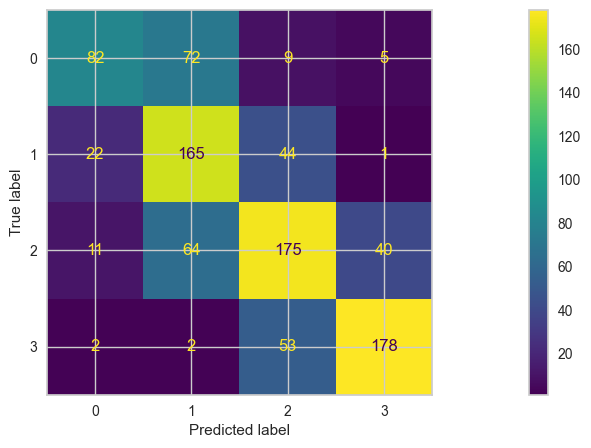

In [25]:
matplotlib.rcParams["figure.figsize"]=(25,5)
ConfusionMatrixDisplay(confusion_matrix(y_test,predicted)).plot()

In [26]:
from sklearn.multiclass import OneVsRestClassifier

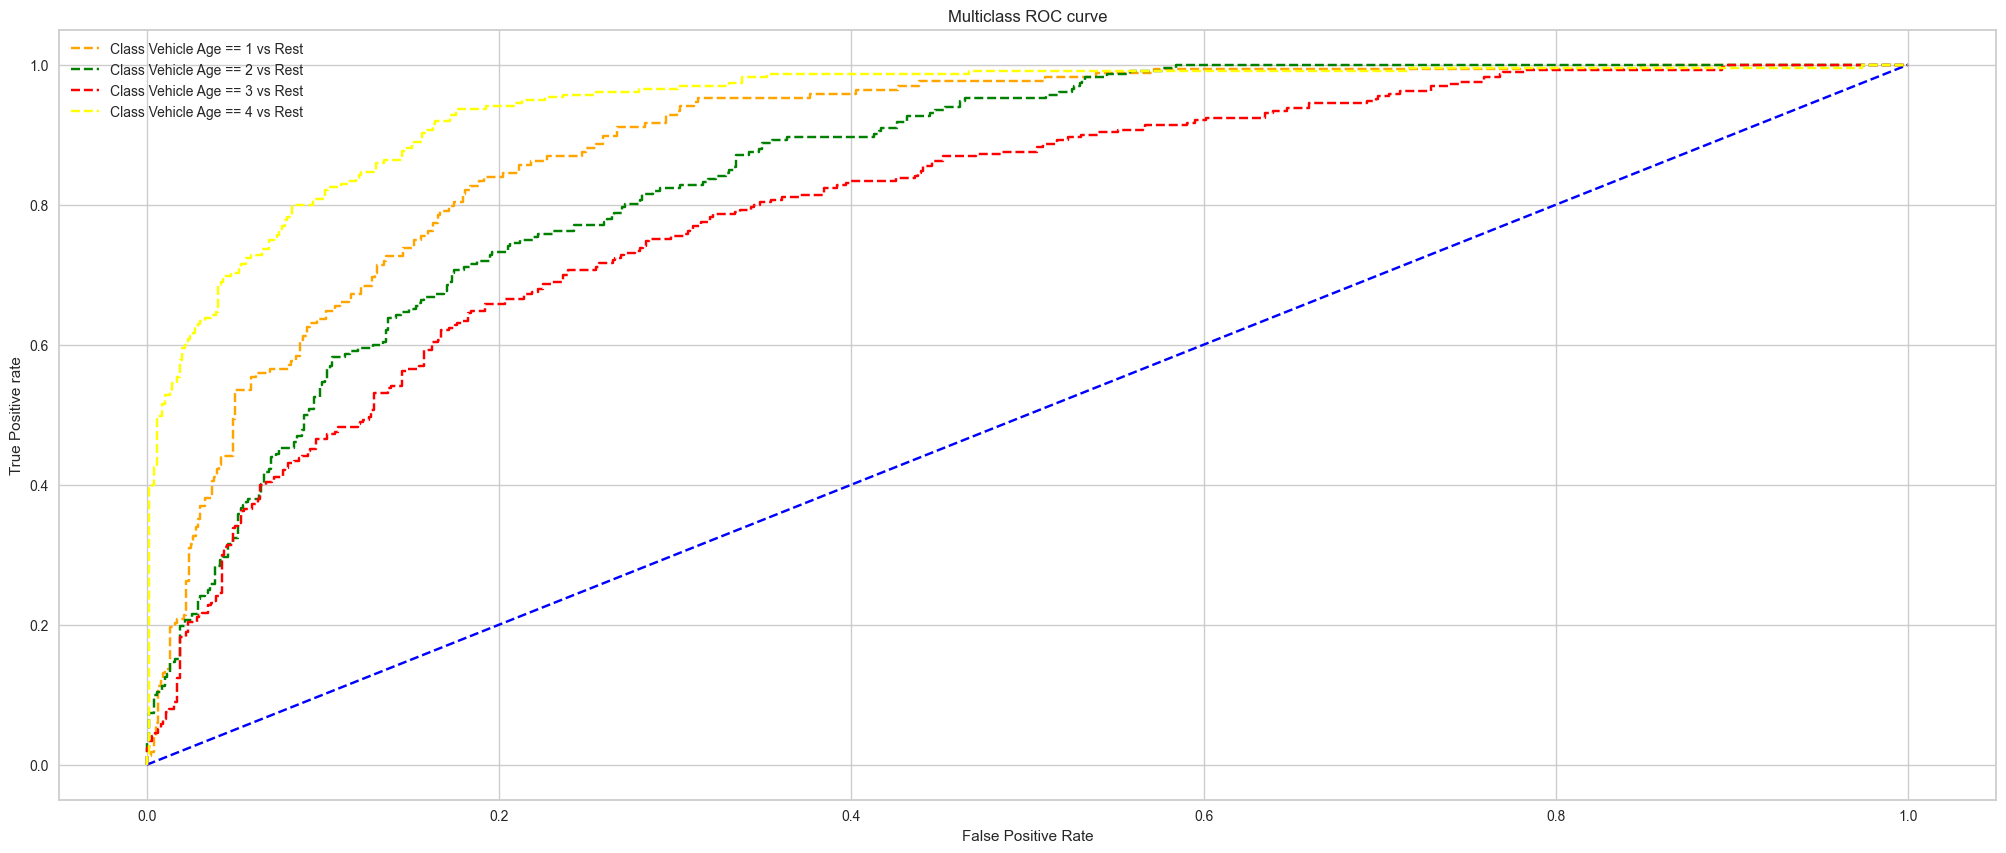

In [27]:
matplotlib.rcParams["figure.figsize"]=(25,10)
clf = OneVsRestClassifier(GradientBoostingClassifier(
    subsample=1,
    n_estimators= 90,
    max_depth= 3,
    learning_rate=0.1,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features="sqrt")).fit(x_train,y_train)


clf.fit(x_train, y_train)
pred = clf.predict(x_test)
pred_prob = clf.predict_proba(x_test)

# roc curve for classes
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Vehicle Age == 1 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Vehicle Age == 2 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class Vehicle Age == 3 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class Vehicle Age == 4 vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300);    

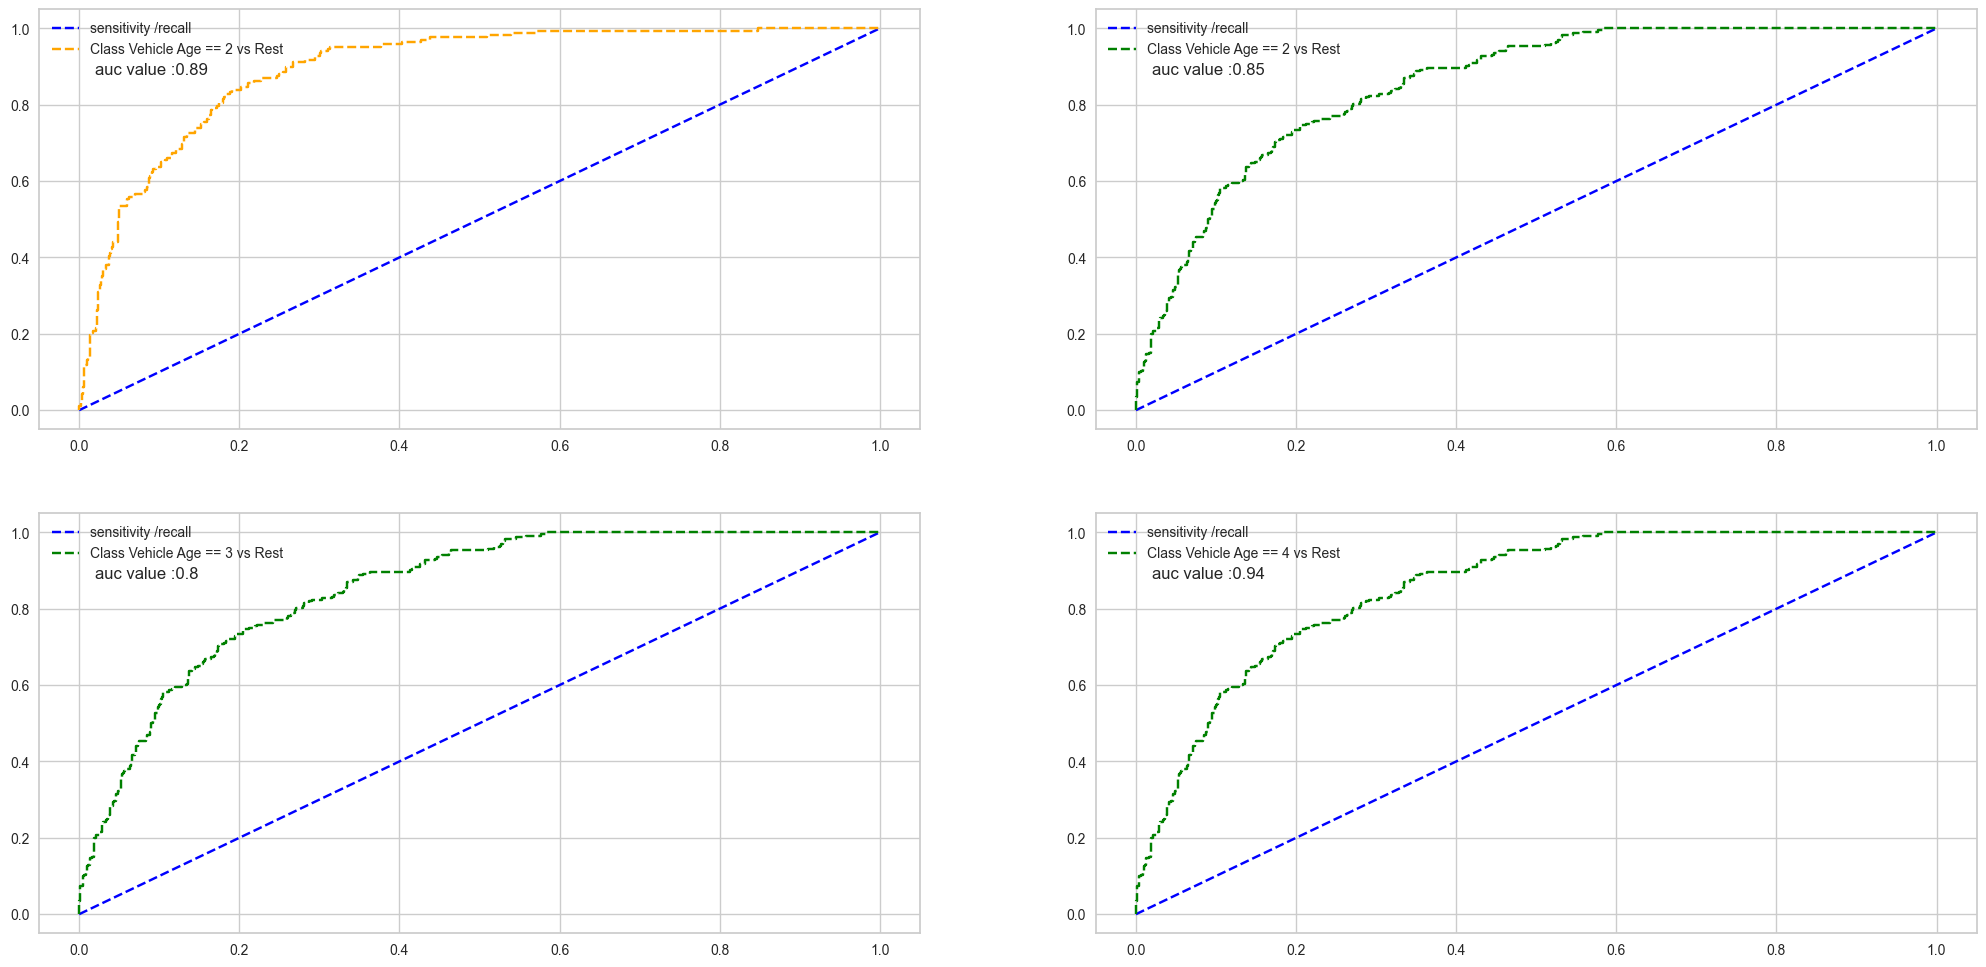

In [28]:
matplotlib.rcParams["figure.figsize"]=(25,12)
plt.subplot(221)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 2 vs Rest'])

plt.subplot(222)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 2 vs Rest'])

plt.subplot(223)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[2], tpr[2]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 3 vs Rest'])

plt.subplot(224)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[3], tpr[3]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 4 vs Rest'])

In [29]:
importance=pd.concat([pd.DataFrame(df.drop("veh_age",axis=1).columns,columns=["feature_names"]),
           pd.DataFrame(model.feature_importances_,columns=["feature_importances"])],axis=1)

In [30]:
importance

,feature_names,feature_importances
0,veh_value,0.745008
1,exposure,0.018929
2,numclaims,0.002859
3,claimcst0,0.020612
4,veh_body,0.118773
5,gender,0.009482
6,area,0.014954
7,agecat,0.008911
8,severity,0.020428
9,frequincy,0.018767


In [31]:
Veh_ageImportanceTabel=importance.sort_values(by='feature_importances',ascending=False)
Veh_ageImportanceTabel.to_pickle("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Table/Veh_ageImportanceTabel.pkl")

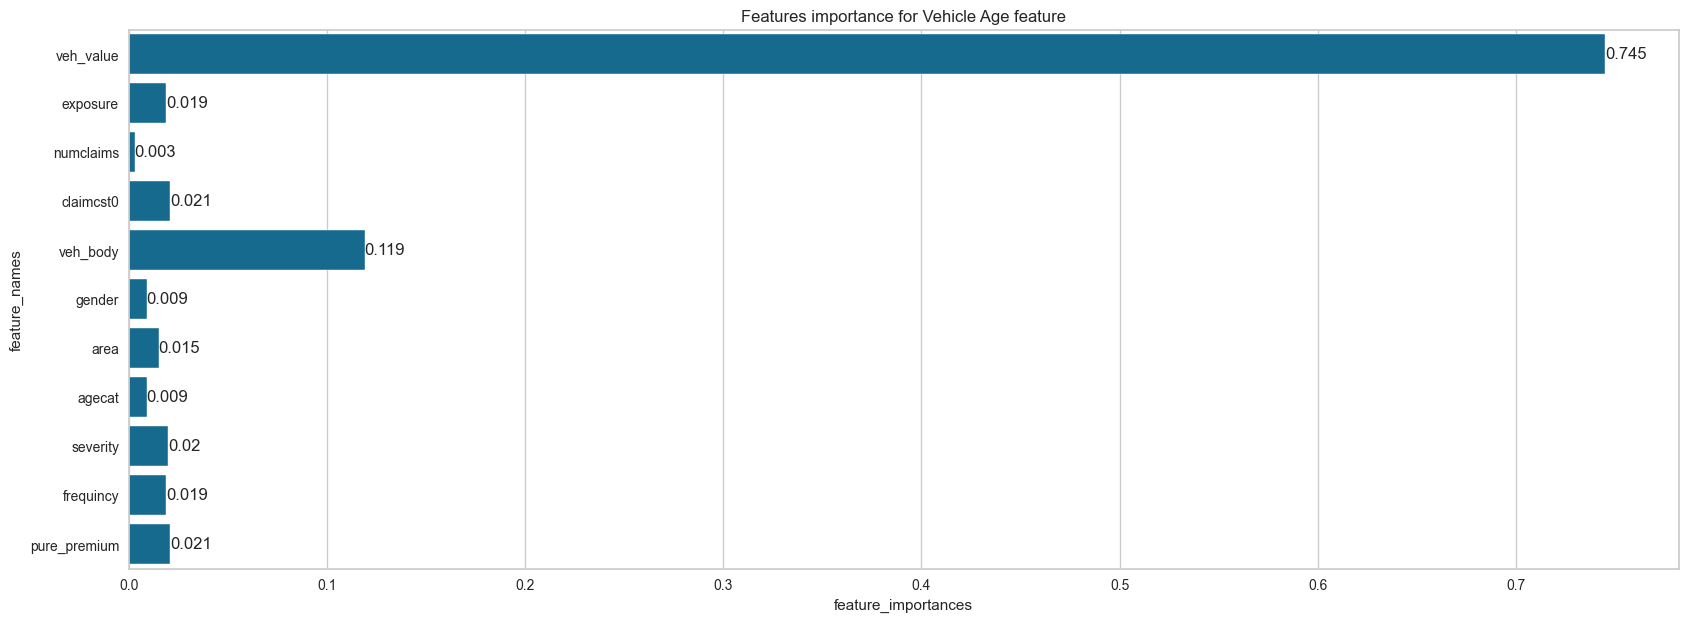

In [32]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Vehicle Age feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Graph/Veh_age_featureImportanc',dpi=500);

In [33]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/vehage_prediction_model.pkl","wb") as f:
    pickle.dump(model,f)

---